# Environment setup

## Import libraries

In [ ]:
import os, os.path, json, folium, requests, re, time, math
from folium import plugins
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import MarkerCluster
import requests; from urllib.parse import urlparse
import pandas as pd
import plotly.express as px
import numpy as np
from tqdm import tqdm

## Pandas setup

In [ ]:
# Limit the decimal points to two
pd.options.display.float_format = '{:.2f}'.format

## Matplotlib setup

In [ ]:
# Set global parameters for font size, axes, and tick labels
plt.rcParams.update({
    'font.size': 12,      # Set font size
    'axes.labelsize': 14, # Set label size
    'axes.titlesize': 16, # Set title size
    'xtick.labelsize': 10,# Set xtick label size
    'ytick.labelsize': 10 # Set ytick label size
})

## Mount Google Drive in Google Colab

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# move to directory with dataset
%cd '/content/drive/MyDrive/2024_1학기/Code_Review/실험/data'
# %cd '/content/drive/MyDrive/PATH/TO/YOUR/data'

/content/drive/MyDrive/2024_1학기/Code_Review/실험/data


In [ ]:
# check current workplace
!pwd

/content/drive/MyDrive/2024_1학기/Code_Review/실험/data


## Dictionary for Korean-English train line

In [ ]:
RailLines_translation_dict = {
    '경강선': 'Gyeonggang\nLine',
    '경부선': 'Gyeongbu\nLine',
    '경춘선': 'Gyeongchun\nLine',
    '수여선': 'Suyeon\nLine',
    '수인선': 'Suin\nLine',
    '중앙선': 'Jungang\nLine',
    '경부고속선': 'Gyeongbu High-Speed\nLine',
    '경전선': 'Gyeongjeon\nLine',
    '동해남부선': 'Donghae South\nLine',
    '동해중부 미건설선': 'Donghae Central\nUnconstructed Line',
    '임항선': 'Imhang\nLine',
    '대전남연결선': 'Daejeon South\nConnection Line',
    '문경선': 'Mungyeong\nLine',
    '장항선': 'Janghang\nLine',
    '경전선 추가': 'Additional Gyeongjeon\nLine',
    '삼학도선': 'Samhakdo\nLine',
    '전라선': 'Jeolla\nLine',
    '호남선': 'Honam\nLine',
    '영동선': 'Yeongdong\nLine',
    '태백선': 'Taebaek\nLine',
    '수인선(선로상부)': 'Suin\nLine (Overhead)',
    '경의선(선로상부)': 'Gyeongui\nLine (Overhead)',
    '고속선(선로상부)': 'High-Speed\nLine (Overhead)',
    '호남고속선': 'Honam High-Speed\nLine'
}

## Data preparation

### NREL API for the forecasted solar irradiance and PV power production data
- Monthly forecasted solar irradiance
- Monthly forecasted PV power production
- Annual forecasted solar irradiance
- Annual forecasted PV power production

In [ ]:
df = pd.read_csv("./국가철도공단_철도유휴부지DB_20210902.csv",encoding='cp949')
df_Location = pd.read_csv('./location.csv')

In [ ]:
# Nrel API로 일사량과 전력 예
def calNreldata_monthly(system_capacity = 4, azimuth = 180, tilt = 20,lat = 40,lng = -105):   #nrel 사용
    system_capacity = system_capacity * 0.15
    API_KEY="" # Your Nrel API key
    URL_PVWATTS6 =  f"https://developer.nrel.gov/api/pvwatts/v6.json?api_key="+str(API_KEY)+"&lat="+str(lat)+"&lon="+str(lng)+"&system_capacity="+ str(system_capacity)+"&azimuth=180&tilt=40&array_type=1&module_type=1&losses=10"

    response = requests.get(URL_PVWATTS6)
    json_obj = response.json()
    try:
      ac_annual = json_obj['outputs']['ac_annual']
      solrad_mon = list(json_obj['outputs']['solrad_monthly'])
      ac_Mon = list(json_obj['outputs']['ac_monthly'])
      solrad_annual = json_obj['outputs']['solrad_annual']

      return ac_annual,solrad_mon,ac_Mon,solrad_annual

    except : return ['0', '0', '0', '0']

df = df.loc[:,['재산 소재지','노선명',' 면적(공부) ','현재 사용현황']]        # 필요한 값만 가져온다. df = 국가철도공단_철도유휴부지DB_20210902.csv
# 폐철도 데이터에 location_df의 lat,lng 칼럼 붙이기.
df['lat'] = df_Location.iloc[:,1]
df['lng'] = df_Location.iloc[:,2]
Location = list()        # 주소를 담을 변수
Area = list()
Utilize = list()

if __name__ == '__main__':
    Len = len(df.iloc[:,1])
    for i in range(10):        # 10개 데이터만 nrel에 넣는다. 10 대신 Len을 넣으면 전체 데이터를 다 가져온다.
        area = df.loc[i,' 면적(공부) ']  #면적 받아오기
        lat = df.loc[i,'lat']   # 위도
        lng = df.loc[i,'lng']   # 경도

        ac_annual,solrad_mon,ac_Mon,solrad_annual = calNreldata_monthly(area,180,40,lat,lng)

        if ac_annual == '0' and solrad_mon == '0' and ac_Mon == '0' and solrad_annual == '0': continue
        # 만약 위경도가 잘못됐다면 continue한다.
        Location.append(df.iloc[i,0])
        railwayLine.append(df.loc[i,'노선명'])
        Area.append(df.loc[i,' 면적(공부) '])
        Utilize.append(df.loc[i,'현재 사용현황'])
        if i==0:
          # 처음 반복문을 돌 때 데이터프레임 생성
          Land_df2=pd.DataFrame([ac_Mon+solrad_mon],columns=['ac_monthly_1','ac_monthly_2','ac_monthly_3','ac_monthly_4','ac_monthly_5','ac_monthly_6','ac_monthly_7','ac_monthly_8','ac_monthly_9','ac_monthly_10','ac_monthly_11','ac_monthly_12','solared_mon_1','solared_mon_2',
                                       'solared_mon_3','solared_mon_4','solared_mon_5','solared_mon_6','solared_mon_7','solared_mon_8','solared_mon_9','solared_mon_10','solared_mon_11','solared_mon_12'])
          Land_df2['solrad_annual']=solrad_annual
          Land_df2['ac_annual']=ac_annual
          # 나중에 한글 칼럼 다 영어로 변경 필요 - Nrel_alldata.csv에 주소, 노선명, 면적, 활용여부
          Land_df2['주소'] = Location # 폐철도 df의 재산소재지 칼
          Land_df2['lat'] = lat
          Land_df2['lng'] = lng
          Land_df2['노선명']=railwayLine
          Land_df2['면적'] = Area
          Land_df2['활용여부'] = Utilize

        else:
            Land_df2.loc[i]=ac_Mon+solrad_mon+[solrad_annual]+[ac_annual]+[Location]+[lat]+[lng]+[railwayLine]+[Area]+[Utilize]

  print("Solar radiation and power forecast completed.")
  print("=============================================")

  Land_df2.info()
  print("=============================================")
  Land_df2.to_csv("./data/Nrel_alldata.csv")
  print("Data saving is complete.")



IndentationError: unindent does not match any outer indentation level (<tokenize>, line 59)

### Conversion from road name address to coordinates

In [ ]:
# Comprehensive Information on Abandoned Train Lines
Comprehensive_abandoned_railroads = pd.read_csv('./국가철도공단_철도유휴부지DB_20210902.csv',encoding = 'cp949')

# Using the Coordinates_abandoned_railroads data as an input, retrieve the longitude and latitude values of the abandoned railroad with the Kakao API, and save them in a file named location.csv

def get_location(address):   # Kakao API
  url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + address

  headers = {"Authorization": "KakaoAK 847f4572b1920bfb90d7b7aadd91b4c4"}
  api_json = json.loads(str(requests.get(url,headers=headers).text))
  address = api_json['documents'][0]['address']
  crd = {"lat": str(address['y']), "lng": str(address['x'])} # latitude, longitude
  address_name = address['address_name']

  return crd

def get_latlng():
    cnt = len(Comprehensive_abandoned_railroads.iloc[:,3])
    location=np.zeros([19900,2])

    for i in tqdm(range(0,cnt)):
        try:
            area = Comprehensive_abandoned_railroads.iloc[i,3]
            L = get_location(Comprehensive_abandoned_railroads.iloc[i,1])
            lat, lng = L['lat'], L['lng']
            location[i]=lat,lng
        except IndexError:
          location[i]='9999','9999'
    return location

# Coordinates (Longitudes and latitudes) of the abandoned railroad.
Coordinates_abandoned_railroads = pd.read_csv('./location.csv')

### Data load

In [ ]:
# Forecasting solar radiation by route
Estimated_PV_generation = pd.read_csv("./Nrel_alldata.csv",encoding='cp949')

# Analysis of supply and production in relation to power demand
Map_geo = json.load(open('./TL_SCCO_CTPRVN.json',encoding='utf-8'))

# Photovoltaic Installation Status in 2021
PV_installation_2021 = pd.read_csv('./20220629_태양광+발전소+누적+실치현황.csv')

# Predicted Power Generation by Railroad for Each of the 12 Months
PV_estimated_generation_monthly = pd.read_csv('./data_ac_mon.csv',encoding='cp949')

# Photovoltaic Power Generation Status in 2021
PV_generation_2021 = pd.read_csv('./20220623_2021년+신규+발전량+현황.csv')

# Entire area by train line
Area_by_railLine = pd.read_csv('./train_area.csv')

# Area of abandoned tunnels
Area_of_abandoned_tunnels_by_railLine = pd.read_excel('./정보공개(9656781)_폐터널 현황.xlsx')

# Area of train line
Abandoned_railroads = pd.read_csv("./Nrel_alldata.csv",encoding='cp949')

# 4. Case study of Korea

## 4.0 Background analysis


### a. energy supply situation from 2010 to 2020

In [ ]:
# load data
Energy_supply_situation = pd.read_csv('./10년 에너지 현황.csv',encoding='cp949')

# Analysis of Annual Energy Supply Status by Energy Type
new_columns=['Year', 'Total', 'Coal', 'Oil', 'LNG', 'Hydro Power', 'Nuclear Power', 'Renewable Energy']
Energy_supply_situation.columns=new_columns

a,b,c,d,e,f = list(), list(), list(), list(), list(), list()
def D(val):
    return int(re.sub(',','',val))

for i in range(len(Energy_supply_situation)):
    num = D(Energy_supply_situation.loc[i,'Total'])
    num1 = D(Energy_supply_situation.loc[i,'Hydro Power'])
    num2 = D(Energy_supply_situation.loc[i,'Renewable Energy'])
    num3 = D(Energy_supply_situation.loc[i,'Coal'])
    num4 = D(Energy_supply_situation.loc[i,'Oil'])
    num5 = D(Energy_supply_situation.loc[i,'LNG'])
    num6 = D(Energy_supply_situation.loc[i,'Nuclear Power'])
    a.append(num), b.append(num1 + num2), d.append(num3) , e.append(num4), f.append(num5), c.append(num6)

Energy_supply_situation['Total'], Energy_supply_situation['Renewable Energy'], Energy_supply_situation['Coal'], Energy_supply_situation['Oil'], Energy_supply_situation['LNG'], Energy_supply_situation['Nuclear Power'] = a,b,d,e,f,c

Energy_supply_situation = Energy_supply_situation.loc[:,['Total','Year','Coal','Oil','LNG','Renewable Energy','Nuclear Power']]
x = Energy_supply_situation.loc[:,'Year']
name = Energy_supply_situation.columns
Energy_supply = {}

for i in range(2,7):
    per = list()
    for j in range(11):
        per.append(Energy_supply_situation.iloc[j,i] / Energy_supply_situation.iloc[j,0] * 100)
    Energy_supply[name[i]] = per

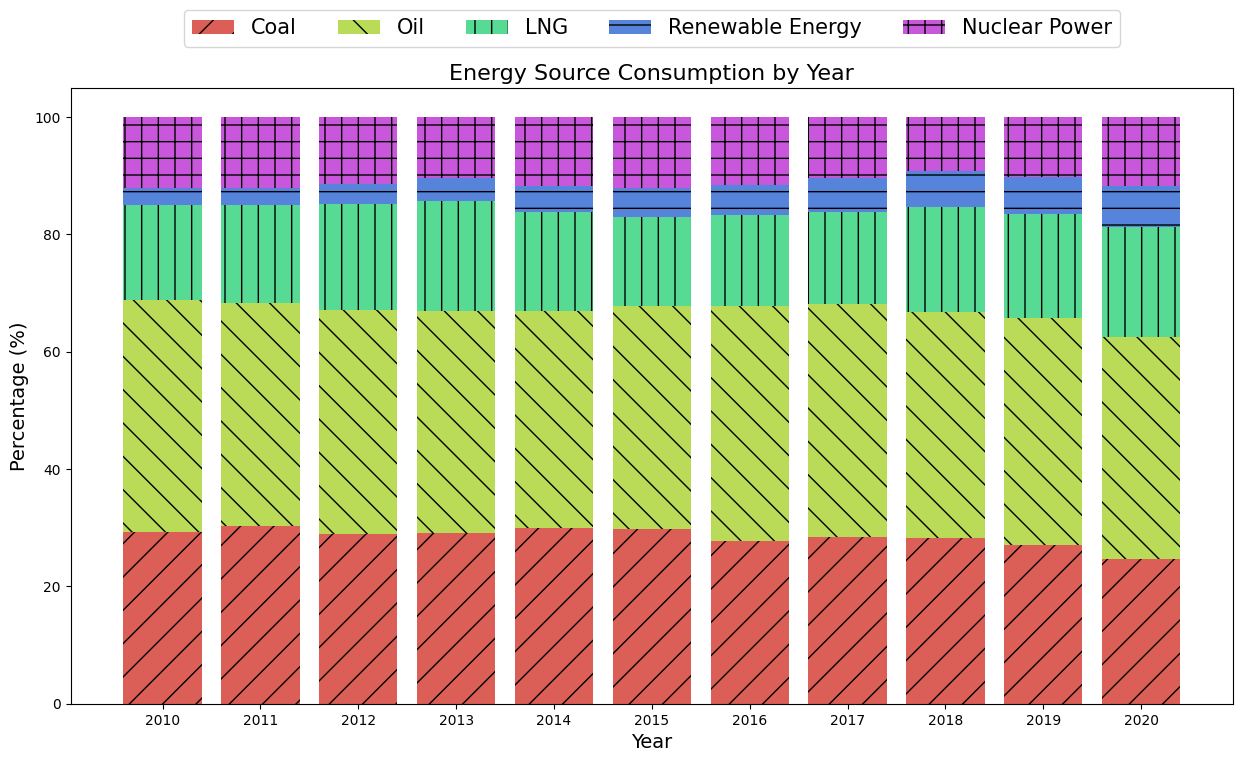

In [ ]:
# Visualized Annual Energy Supply Situation for 10 years
Energy_supply_over_time = pd.DataFrame(Energy_supply,index=x)

patterns = ['/', '\\', '|', '-', '+']
colors = sns.color_palette('hls', 5)

fig, ax = plt.subplots(figsize=(15, 8))
bottom = [0] * len(Energy_supply_over_time.index)

for i, column in enumerate(Energy_supply_over_time.columns):
    ax.bar(Energy_supply_over_time.index, Energy_supply_over_time[column], bottom=bottom, label=column, color=colors[i], hatch=patterns[i % len(patterns)])
    bottom = [bottom[j] + Energy_supply_over_time[column].iloc[j] for j in range(len(Energy_supply_over_time.index))]


plt.ylabel('Percentage (%)')
plt.xlabel('Year')
plt.title('Energy Source Consumption by Year')
plt.xticks(Energy_supply_over_time.index)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=len(Energy_supply_over_time.columns))

plt.show()

### b. Comprehensive analysis of vacant land - abandoned train lines

In [ ]:
Abandoned_railroads_Area = Abandoned_railroads[['면적','활용여부']]

# Area of unDeveloped Abandoned Railroads
unDeveloped_Abandoned_railroads_Area = Abandoned_railroads_Area[Abandoned_railroads_Area['활용여부'] == '미사용']['면적'].sum()
# Area of Developed Abandoned Railroads
Developed_Abandoned_railroads_Area =Abandoned_railroads_Area[Abandoned_railroads_Area['활용여부'] != '미사용']['면적'].sum()

Abandoned_railroads_Region = Abandoned_railroads[['주소','노선명','면적','활용여부']]

unDeveloped_Abandoned_railroads_Region = {
    '전라남도': 0,
    '경상북도': 0,
    '경상남도': 0,
    '강원도': 0,
    '충청북도': 0,
    '경기도': 0,
    '충청남도': 0,
    '부산광역시': 0,
    '제주': 0,
    '울산광역시': 0,
    '인천광역시': 0,
    '대전광역시': 0,
    '서울특별시': 0,
    '전라북도': 0,
    '광주광역시': 0,
    '대구광역시': 0
}

Developed_Abandoned_railroads_Region = {
    '전라남도': 0,
    '경상북도': 0,
    '경상남도': 0,
    '강원도': 0,
    '충청북도': 0,
    '경기도': 0,
    '충청남도': 0,
    '부산광역시': 0,
    '제주': 0,
    '울산광역시': 0,
    '인천광역시': 0,
    '대전광역시': 0,
    '서울특별시': 0,
    '전라북도': 0,
    '광주광역시': 0,
    '대구광역시': 0
}

keys = list(Developed_Abandoned_railroads_Region.keys())

region = {

    '전라남도': '전남',
    '경상북도': '경북',
    '경상남도': '경남',
    '강원도': '강원도',
    '충청북도': '충북',
    '경기도': '경기',
    '충청남도': '충남',
    '부산광역시': '부산',
    '제주': '제주',
    '울산광역시': '울산',
    '인천광역시': '인천',
    '대전광역시': '대전',
    '서울특별시': '서울',
    '전라북도': '전북',
    '광주광역시': '광주',
    '대구광역시': '대구'
}

for i in range(len(Abandoned_railroads_Region)):
  for j in range(len(keys)):
    if keys[j] in Abandoned_railroads_Region.loc[i,'주소']:
      if Abandoned_railroads_Region.loc[i,'활용여부'] == '미사용':
        unDeveloped_Abandoned_railroads_Region[keys[j]] += Abandoned_railroads_Region.loc[i,'면적']
        break
      else:
        Developed_Abandoned_railroads_Region[keys[j]] += Abandoned_railroads_Region.loc[i,'면적']
        break

unDeveloped_Ar = dict([(region.get(key), value) for key, value in unDeveloped_Abandoned_railroads_Region.items()])
Developed_Ar = dict([(region.get(key), value) for key, value in Developed_Abandoned_railroads_Region.items()])

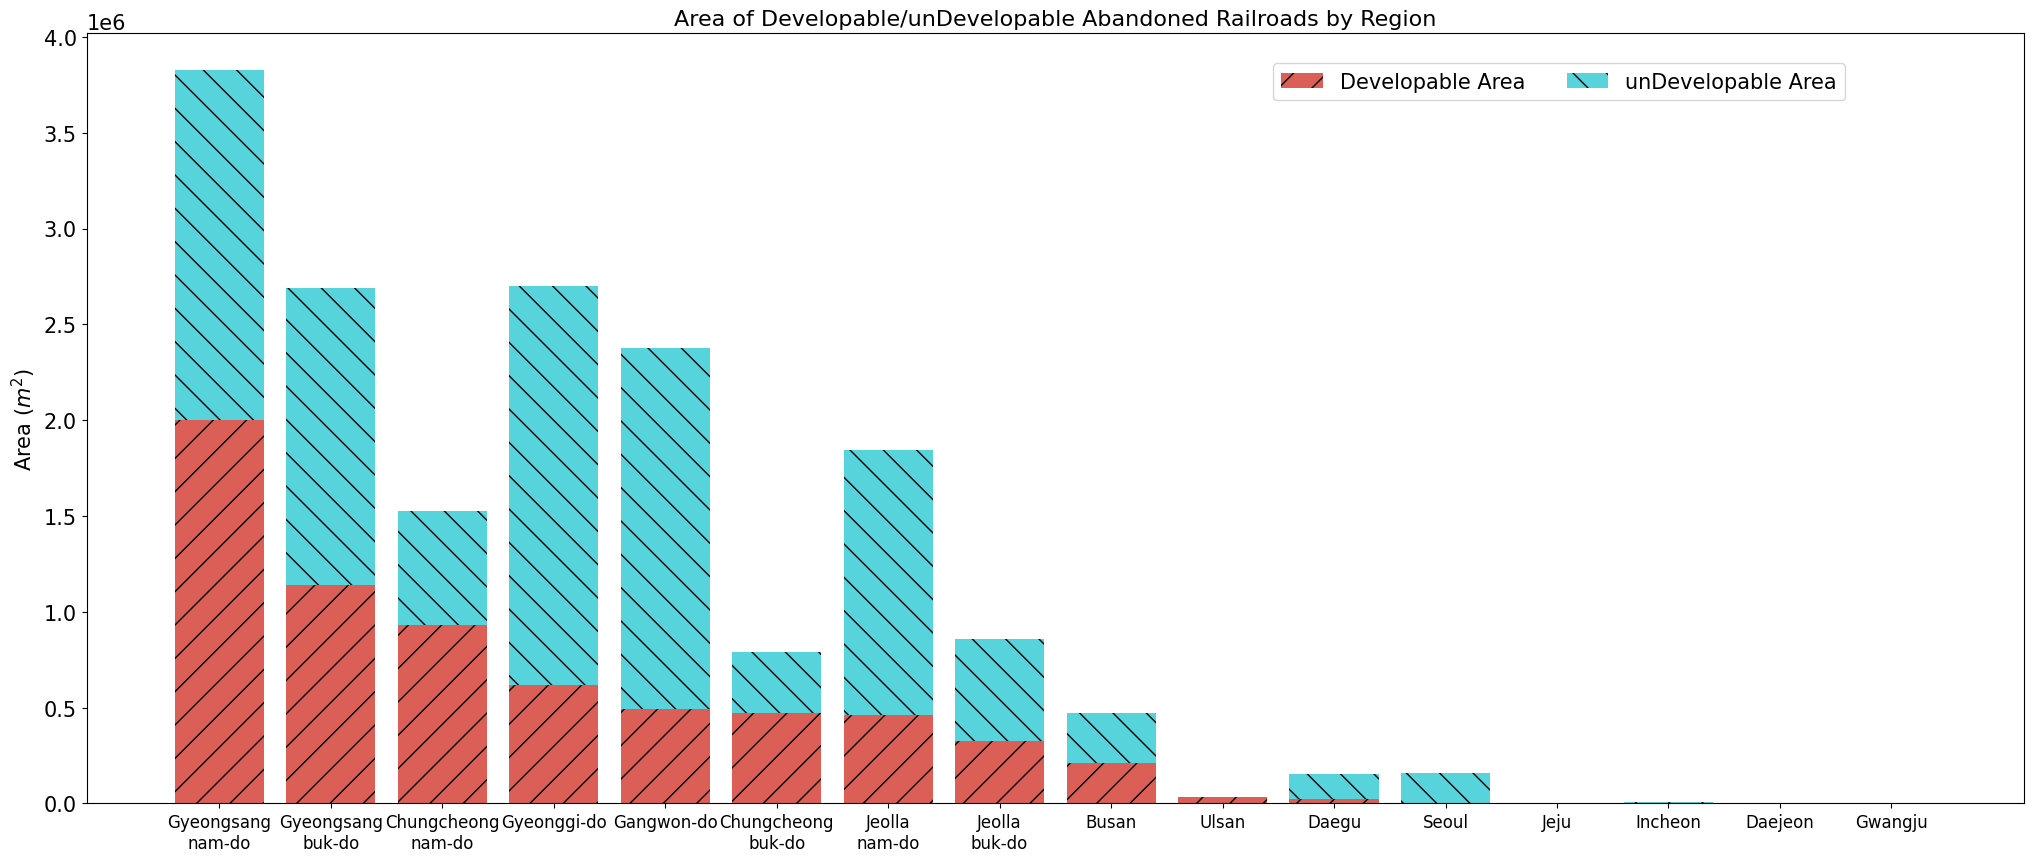

In [ ]:
# Visualization on the Area of Abandoned Railroads

x = list(Developed_Ar.keys())
data = {
    "Developable Area": unDeveloped_Ar.values(),
    "unDevelopable Area": Developed_Ar.values()
}

DevZone = pd.DataFrame(data,index=x)

# sorting by area of developable section
DevZone = DevZone.sort_values(by='Developable Area', ascending=False)

# Translate name of regions from Korean to English
regions_translation_dict = {
    '전남': 'Jeolla\nnam-do',
    '경북': 'Gyeongsang\nbuk-do',
    '경남': 'Gyeongsang\nnam-do',
    '강원도': 'Gangwon-do',
    '충북': 'Chungcheong\nbuk-do',
    '경기': 'Gyeonggi-do',
    '충남': 'Chungcheong\nnam-do',
    '부산': 'Busan',
    '제주': 'Jeju',
    '울산': 'Ulsan',
    '인천': 'Incheon',
    '대전': 'Daejeon',
    '서울': 'Seoul',
    '전북': 'Jeolla\nbuk-do',
    '광주': 'Gwangju',
    '대구': 'Daegu'
}

DevZone.rename(index=regions_translation_dict, inplace=True)

# Define patterns and colors
patterns = ['/', '\\']
colors = sns.color_palette('hls', len(DevZone.columns))


# Plotting
fig, ax = plt.subplots(figsize=(25, 10))
bottom = [0] * len(DevZone.index)

plt.rc('font', size=15)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=15)

for i, column in enumerate(DevZone.columns):
    ax.bar(DevZone.index, DevZone[column], bottom=bottom, label=column, color=colors[i], hatch=patterns[i % len(patterns)])
    bottom = [bottom[j] + DevZone[column].iloc[j] for j in range(len(DevZone.index))]

# Styling
plt.ylabel('Area (${m}^2$)')
plt.xticks(DevZone.index)
plt.legend(loc='lower center', bbox_to_anchor=(0.76, 0.9), ncol=len(DevZone.columns))
plt.title('Area of Developable/unDevelopable Abandoned Railroads by Region')
plt.show()

### c. Analysis of supply and production in relation to power demand

In [ ]:
# Data engineering before the Visualization on the power generation
# Photovoltaic Power Generation Status in 2021
region = ['서울','부산','대구','인천','광주','대전','울산','세종','경기','강원','충청북도','충청남도','전라북도','전라남도','경상북도','경상남도','제주']

All_Sum = list()
for i in range(len(PV_generation_2021)):
    Sum = 0
    for j in range(1,13):
        Sum += float(re.sub(',','',PV_generation_2021.iloc[i,j]))
    All_Sum.append(int(Sum))

PV_generation_2021['2021 신규 태양광 발전량'] = All_Sum

for i in range(len(PV_generation_2021)):
  PV_generation_2021.loc[i,'구분'] = region[i]

location, temp = list(), list()

for idx,dic in enumerate(Map_geo['features']):
  for i in range(len(PV_generation_2021)):
    if PV_generation_2021.loc[i,'구분'] in dic['properties']['CTP_KOR_NM']:
      location.append(PV_generation_2021.loc[i,'구분']), temp.append(PV_generation_2021.loc[i,'2021 신규 태양광 발전량'])

PV_generation_2021 = pd.DataFrame({'구분':location,'발전량':temp})

In [ ]:
PV_estimated_generation_monthly.drop(columns={'Unnamed: 0'},axis=0,inplace=True)
PV_installation_2021 = PV_installation_2021.loc[:,['구분','누적 발전소 개소(2021년까지)']]
PV_installation_2021.rename(columns={'구분':'name','누적 발전소 개소(2021년까지)':'태양 전지 개수'},inplace=True)

location, temp = list(), list()

# geojson파일과 같도록 전처리 한다.
for idx,dic in enumerate(Map_geo['features']):
  for i in range(len(PV_installation_2021)):
    if PV_installation_2021.loc[i,'name'] in dic['properties']['CTP_KOR_NM']:
      location.append(PV_installation_2021.loc[i,'name']), temp.append(PV_installation_2021.loc[i,'태양 전지 개수'])

PV_installation_2021 = pd.DataFrame({'name':location,'태양 전지 개수':temp})

In [ ]:
# Visualization on the expected power generation after the installation on abandoned railroads
for idx,dic in enumerate(Map_geo['features']):
    dic['properties'].update({'name':str(PV_installation_2021.iloc[idx,0]),'태양 전지 개수':str(PV_installation_2021.iloc[idx,1]),'html':str(0)})
    txt = f'<b><h4>{PV_installation_2021.iloc[idx,0]}</h4></b>연간 예측 전력 발전량: {str(PV_estimated_generation_monthly.iloc[idx,1])}'
    dic['properties']['html'] = txt


m = folium.Map(
    location=[37.559819, 126.963895],
    tiles='OpenStreetMap',
    zoom_start=7,
)

cho = folium.Choropleth(
    geo_data=Map_geo,
    data=PV_estimated_generation_monthly,
    fill_color='OrRd',
    columns=['주소','ac_annual'],
    key_on = 'feature.properties.name',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Annual Predicted PV Power Generation'
).add_to(m)

cho.geojson.add_child(folium.features.GeoJsonTooltip(['html'],labels=False))
title_html = '<h3 align="center" style="font-size:20px"><b>Annual Predicted PV Power Generation</b></h3>'
m.get_root().html.add_child(folium.Element(title_html))

m

## 4.1 Potential analysis

$$\alpha_{fixed}=\cos^{-1}[\sin(\theta_{sun})\cos(\gamma-\gamma_{sun})\sin(\beta)+\cos(\theta_{sun})\cos(\beta)] \tag{6}$$

$$I_{poa}(\text{r}_i)=I_b+I_{d,sky}+I_{d,ground} \tag{7}$$

### a. Forecasting solar radiation by route

$$R^{solar}(R)=Sigmoid(desc(\{I_{poa}(r_i) \ | \ r_i \in R\})) \tag{9}$$

$$R^{idle}(R)=Sigmoid(desc(\{E(r_i) \ | \ r_i \in R\})) \tag{10}$$

$$R^{imped}(R)=\sum_{i=1}^n(S(r_i) \ - \ S_{imped}(r_i)) \tag{11}$$

In [ ]:
# Retrieving the Estimated Solar Insolation for the 12 Months
Mon = ['January','February','March','April','May','June','July','August','September','October','November','December','노선명']
Estimated_PV_generation_monthly = Estimated_PV_generation.iloc[:,13:25]
Estimated_PV_generation_monthly['노선명'] = Estimated_PV_generation.loc[:,'노선명']
Estimated_PV_generation_monthly.columns = Mon
Estimated_PV_generation_monthly = Estimated_PV_generation_monthly.groupby('노선명').sum().astype(int)

All_sum = list()

for i in range(len(Estimated_PV_generation_monthly)):
    Sum = 0
    for j in range(12):
        Sum += Estimated_PV_generation_monthly.iloc[i,j]
    All_sum.append(Sum)


Estimated_PV_generation_monthly['총 태양 일사량'] = All_sum
Estimated_PV_generation_monthly.sort_values(by='총 태양 일사량',ascending=False,inplace=True)
Estimated_PV_generation_monthly.drop(columns={'총 태양 일사량'},inplace=True)

# Define X axis with Months
x = list(Estimated_PV_generation_monthly.columns)

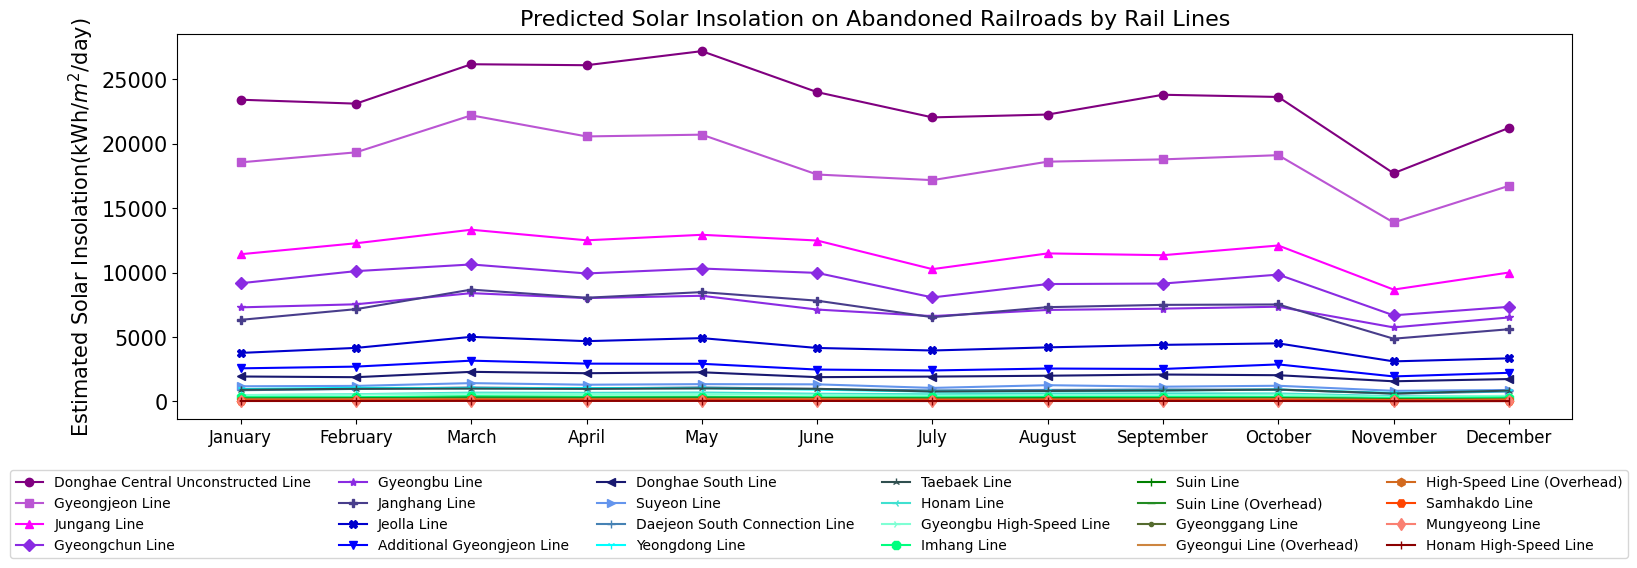

In [ ]:
# Visualization on the Estimated Power Generation by Rail Line
# All 25 Train Lines except for 'Sanjae Unused Land' are plotted

plt.figure(figsize=(18,5))

markers = ['o', 's', '^', 'D', '*', 'P', 'X', 'v', '<', '>', '+', '1', '2', '3', '4', '8', '|', '_', '.', ',', 'h', 'H', 'd', '|', '_']

# Drop the column 'Sanjae Unused Land'
Estimated_PV_generation_monthly.drop(index=['산재 유휴부지'], inplace=True)

name = Estimated_PV_generation_monthly.index
name_legend = railway_lines = ['Donghae Central Unconstructed Line', 'Gyeongjeon Line', 'Jungang Line', 'Gyeongchun Line', 'Gyeongbu Line',
                 'Janghang Line', 'Jeolla Line', 'Additional Gyeongjeon Line', 'Donghae South Line',
                 'Suyeon Line', 'Daejeon South Connection Line', 'Yeongdong Line', 'Taebaek Line', 'Honam Line', 'Gyeongbu High-Speed Line',
                 'Imhang Line', 'Suin Line', 'Suin Line (Overhead)', 'Gyeonggang Line', 'Gyeongui Line (Overhead)',
                 'High-Speed Line (Overhead)', 'Samhakdo Line', 'Mungyeong Line', 'Honam High-Speed Line'] # English name of each train lines


color = ['purple','mediumorchid','magenta','blueviolet','blueviolet','darkslateblue','mediumblue','b','midnightblue','cornflowerblue','steelblue','aqua','darkslategray','turquoise'
         ,'aquamarine','springgreen','green','forestgreen','darkolivegreen','peru','chocolate','orangered','salmon','darkred']

for i in range(len(Estimated_PV_generation_monthly)):

    y = list(Estimated_PV_generation_monthly.loc[name[i]])
    plt.plot(x, y, marker=markers[i], linestyle='-', color=color[i], label=name[i])

plt.title('Predicted Solar Insolation on Abandoned Railroads by Rail Lines')

plt.rc('font', size=14)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)
plt.ylabel('Estimated Solar Insolation(kWh/$m^2$/day)')
plt.legend(name_legend,loc='lower center', ncol=6,fontsize=10.0, bbox_to_anchor=(0.46, -0.38))
plt.show()

### b. Measuring the developable area by route

In [ ]:
# This process selects segments from the abandoned railroad data that are deemed devlopable for installing photovoltaic power generators.
Developable_Section=Estimated_PV_generation[Estimated_PV_generation['활용여부']=='미사용']
unDevelopable_Section=Estimated_PV_generation[Estimated_PV_generation['활용여부']!='미사용']

In [ ]:
# Data engineering before the Visualization on the Proportion of Installable Photovoltaic Power Generator Area by Abandoned Railroad

Developable_Section_Area=Developable_Section[['노선명','면적','활용여부']]
unDevelopable_Section_Area=unDevelopable_Section[['노선명','면적','활용여부']]

Developable_Section_group=Developable_Section_Area.groupby('노선명')
unDevelopable_Section_group=unDevelopable_Section_Area.groupby('노선명')

RailLines = ['경강선', '경부선', '경춘선', '수여선', '수인선', '중앙선', '경부고속선', '경전선', '동해남부선',
     '동해중부 미건설선', '산재 유휴부지', '임항선', '대전남연결선', '문경선', '장항선', '경전선 추가',
     '삼학도선', '전라선', '호남선', '영동선', '태백선', '수인선(선로상부)', '경의선(선로상부)',
     '고속선(선로상부)', '호남고속선']

# Calculation on the cumulative area for each rail line among the developable rail lines.
# 사용 가능한 부지의 노선별 면적합 구하기
def calc_developable_areaSum(all_train):
  area_sum=[]
  for i in range(25):
    try:
      # 노선별로 분리하고 합계를 구한다
      train_obj=Developable_Section_group.get_group(RailLines[i])
      # 노선별 면적의 합을 구하고 리스트에 append()
      area_sum.append(train_obj['면적'].sum())

    except:
      area_sum.append(0);


  # 다 구해졌으면 노선별 면적합을 Series 형태로 반환
  area_df=pd.Series(area_sum,index=all_train)
  return area_df

# Calculation on the cumulative area for each rail line among the undevelopable rail lines.
# 사용 불가능한 부지의 노선별 면적합 구하기
def calc_undevelopable_areaSum(all_train):
  area_sum=[]
  train_obj=0
  for i in range(25):
      try:
        # 노선별로 분리하고 합계를 구한다
        train_obj=unDevelopable_Section_group.get_group(RailLines[i])
        # 노선별 면적의 합을 구하고 리스트에 append()
        area_sum.append(train_obj['면적'].sum())
      except:
        area_sum.append(0);

  area_df=pd.Series(area_sum,index=all_train)
  return area_df

# Calculation on the total area for developable abandoned railroads.
# 개발 가능한 폐철도 부지 면적합 구하기
Developable_Area = calc_developable_areaSum(RailLines)

# Calculation on the total area for undevelopable abandoned railroads.
# 개발 불가능한 폐철도 부지 면적합 구하기
unDevelopable_Area = calc_undevelopable_areaSum(RailLines)

In [ ]:
unDevelopable_Area

경강선            12028
경부선          1119911
경춘선          1454825
수여선            79599
수인선            38634
중앙선          1562991
경부고속선         165640
경전선          1577321
동해남부선         153770
동해중부 미건설선    1199080
산재 유휴부지       129817
임항선            71922
대전남연결선        131855
문경선             4109
장항선           574142
경전선 추가        434361
삼학도선               0
전라선          1078118
호남선           209757
영동선           612653
태백선                0
수인선(선로상부)      84005
경의선(선로상부)      76254
고속선(선로상부)      21708
호남고속선           9463
dtype: int64

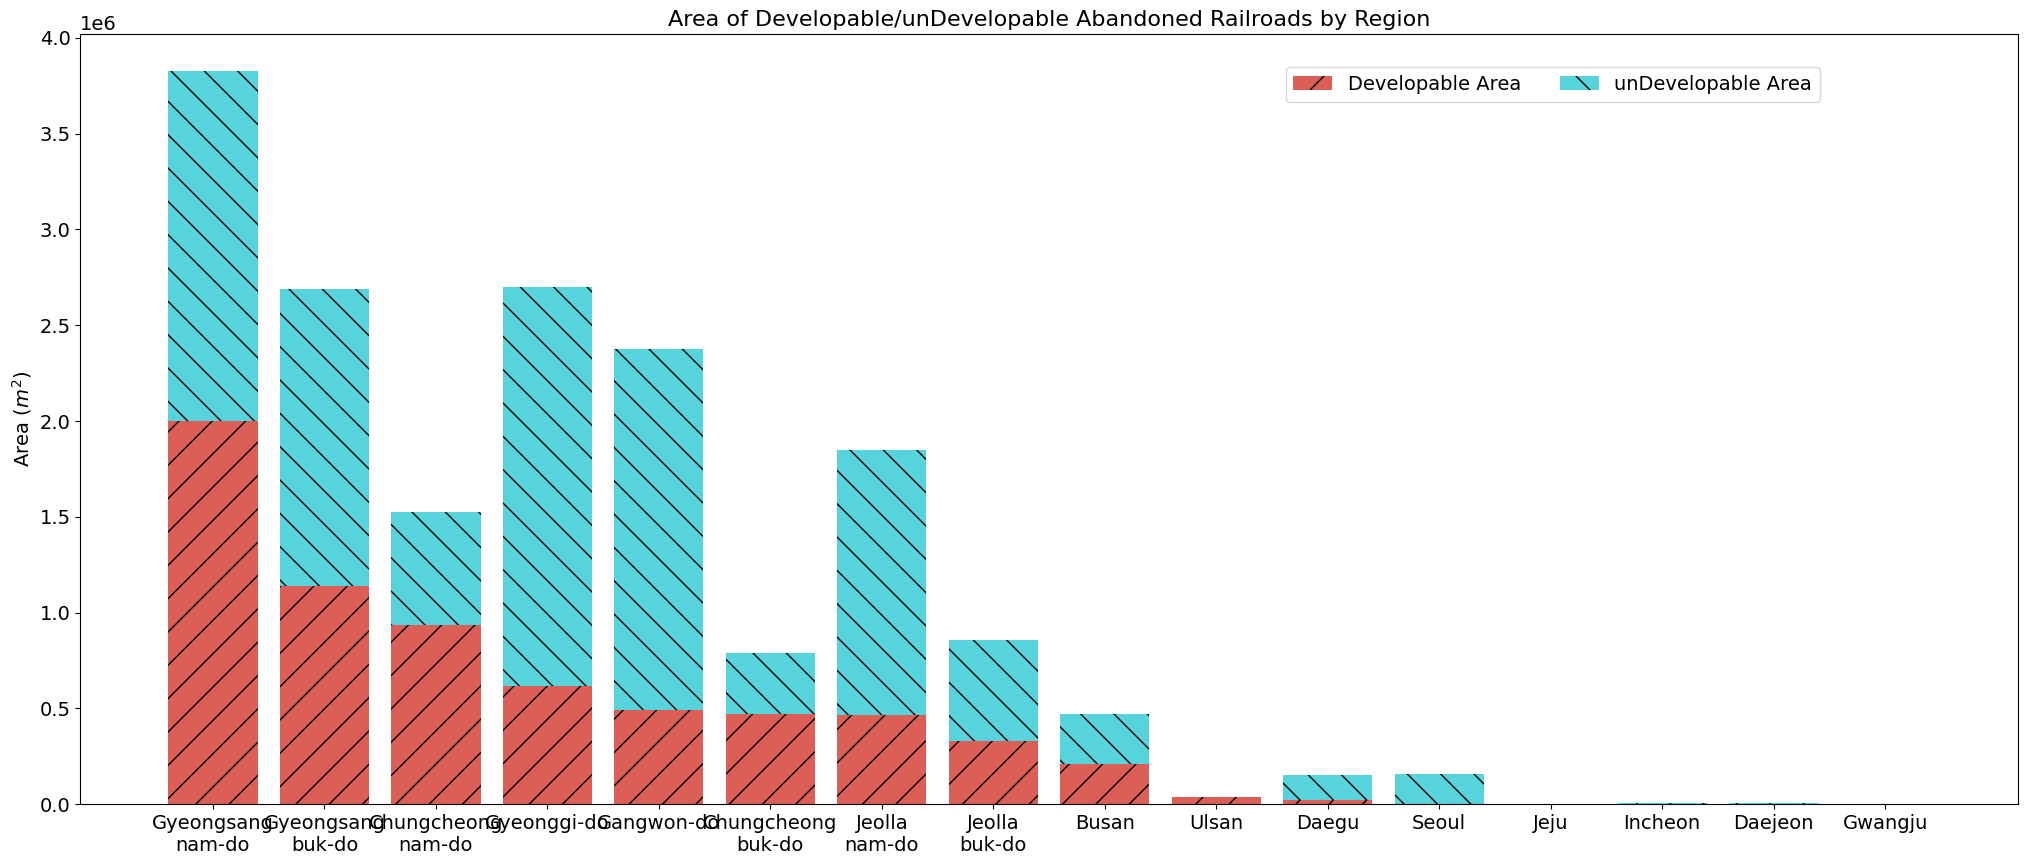

In [ ]:
# Define patterns and colors
patterns = ['/', '\\']
colors = sns.color_palette('hls', len(DevZone.columns))


# Plotting
fig, ax = plt.subplots(figsize=(25, 10))
bottom = [0] * len(DevZone.index)

plt.rc('font', size=15)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=15)

for i, column in enumerate(DevZone.columns):
    ax.bar(DevZone.index, DevZone[column], bottom=bottom, label=column, color=colors[i], hatch=patterns[i % len(patterns)])
    bottom = [bottom[j] + DevZone[column].iloc[j] for j in range(len(DevZone.index))]

# Styling
plt.ylabel('Area (${m}^2$)')
plt.xticks(DevZone.index)
plt.legend(loc='lower center', bbox_to_anchor=(0.76, 0.9), ncol=len(DevZone.columns))
plt.title('Area of Developable/unDevelopable Abandoned Railroads by Region')
plt.show()

In [ ]:
import matplotlib as mlp
import itertools

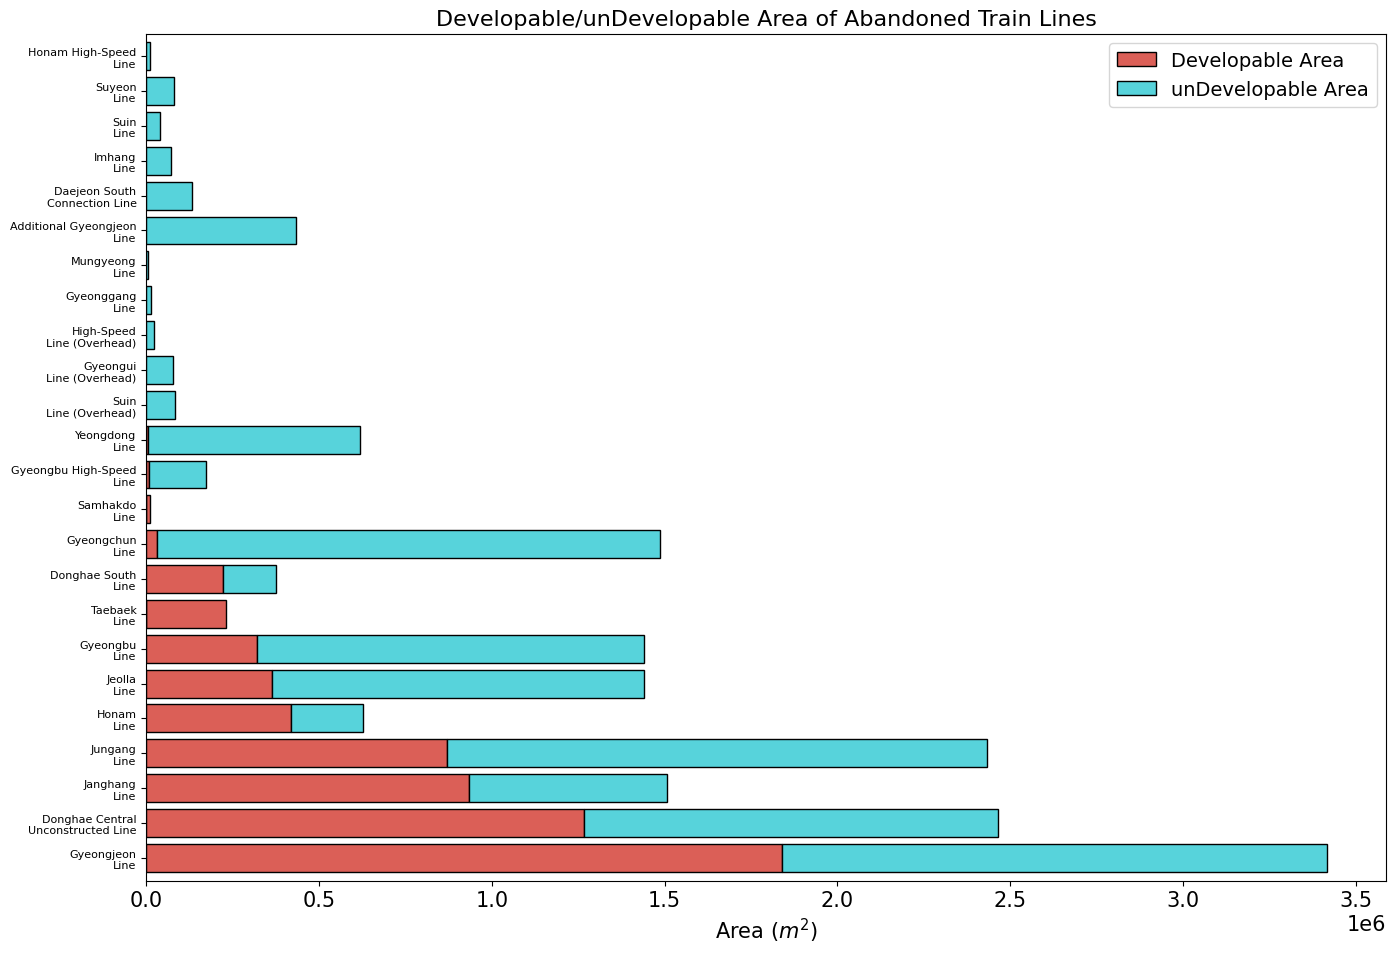

In [ ]:
# Visualization on the Proportion of Installable Photovoltaic Power Generator Area by Abandoned Railroad

Entire_Area_values={
    "Developable Area": Developable_Area.values,
    "unDevelopable Area": unDevelopable_Area.values
}

# Set a darker shade of blue using an RGB tuple
dark_blue_color = (0.0, 0.0, 0.5)  # This will give a dark navy blue color

Utilization_Status = pd.DataFrame(Entire_Area_values, index=RailLines)

# Drop the column 'Sanjae Unused Land'
Utilization_Status.drop(index=['산재 유휴부지'], inplace=True)

sorted_Utilization_Status = Utilization_Status.sort_values(by='Developable Area', ascending=False)

# sorted_top_14_Utilization_Status = sorted_Utilization_Status.nlargest(14, 'Developable Area')

# Translate name of Rail Lines from Korean to English
sorted_Utilization_Status.rename(index=RailLines_translation_dict, inplace=True)

colors = sns.color_palette('hls', len(sorted_Utilization_Status.columns))

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=8)

sorted_Utilization_Status.plot(kind='barh',stacked=True,figsize=(16,11),width=0.8,edgecolor='black',color=colors)

plt.title('Developable/unDevelopable Area of Abandoned Train Lines')
plt.xlabel('Area ($m^2$)')

plt.show()

In [ ]:
Actual_Developable_Section = sorted_Utilization_Status.rename(columns={'Suitable for Photovoltaic Power Generator Installation (Area of Developable Railroads)': 'Developable Area'})

### c. Selecting candidate routes with high potnetial

In [ ]:
# # Extract Top9 Train Lines by developable area
# Actual_Developable_Section = Actual_Developable_Section[:9]

## 4.2 Obstacle analysis

$$R^{imped}(r_i)=\sum_{i=1}^n(S(r_i) \ - \ S_{imped}(r_i)) \tag{11}$$

In [ ]:
# Group distributed abandoned tunnels by train line
Area_of_abandoned_tunnels_by_railLine = Area_of_abandoned_tunnels_by_railLine.loc[:,['선 로 명','연장(m)','폭(m)']].dropna()
Area_of_abandoned_tunnels_by_railLine = Area_of_abandoned_tunnels_by_railLine[Area_of_abandoned_tunnels_by_railLine.loc[:,'연장(m)'] != '측정불가'].reset_index()
Area_of_abandoned_tunnels_by_railLine.drop(columns={'index'},inplace=True)

Area_of_abandoned_tunnels_by_railLine = Area_of_abandoned_tunnels_by_railLine.groupby('선 로 명',as_index=False).sum().sort_values(by='연장(m)',ascending=False).reset_index()
Area_of_abandoned_tunnels_by_railLine.drop(columns={'index'},inplace=True)

In [ ]:
# Data engineering before the Visualization of the area of abandoned railroad tunnels

Area_of_abandoned_tunnels=Area_of_abandoned_tunnels_by_railLine.loc[[0,1,2,3,4,6,13],:]

Area_of_abandoned_tunnels=Area_of_abandoned_tunnels.reset_index()
del Area_of_abandoned_tunnels['index']

# Synchronization of Rail Lines
Area_of_abandoned_tunnels.loc[3] = ['동해중부 미건설선', '3590.00', '30.0']
Area_of_abandoned_tunnels.loc[7] = ['장항선', '0.01', '0.01']
Area_of_abandoned_tunnels.loc[8] = ['동해남부선', '0.01', '0.01']

# Modification on data type of columns
Area_of_abandoned_tunnels['연장(m)']=Area_of_abandoned_tunnels['연장(m)'].astype('float')
Area_of_abandoned_tunnels['폭(m)']=Area_of_abandoned_tunnels['폭(m)'].astype('float')

# The total area of abandoned tunnels for the final 9 railroads.
Rail_lines = Area_of_abandoned_tunnels['선 로 명']
Abandoned_tunnels_Area = Area_of_abandoned_tunnels['연장(m)'] * Area_of_abandoned_tunnels['폭(m)']

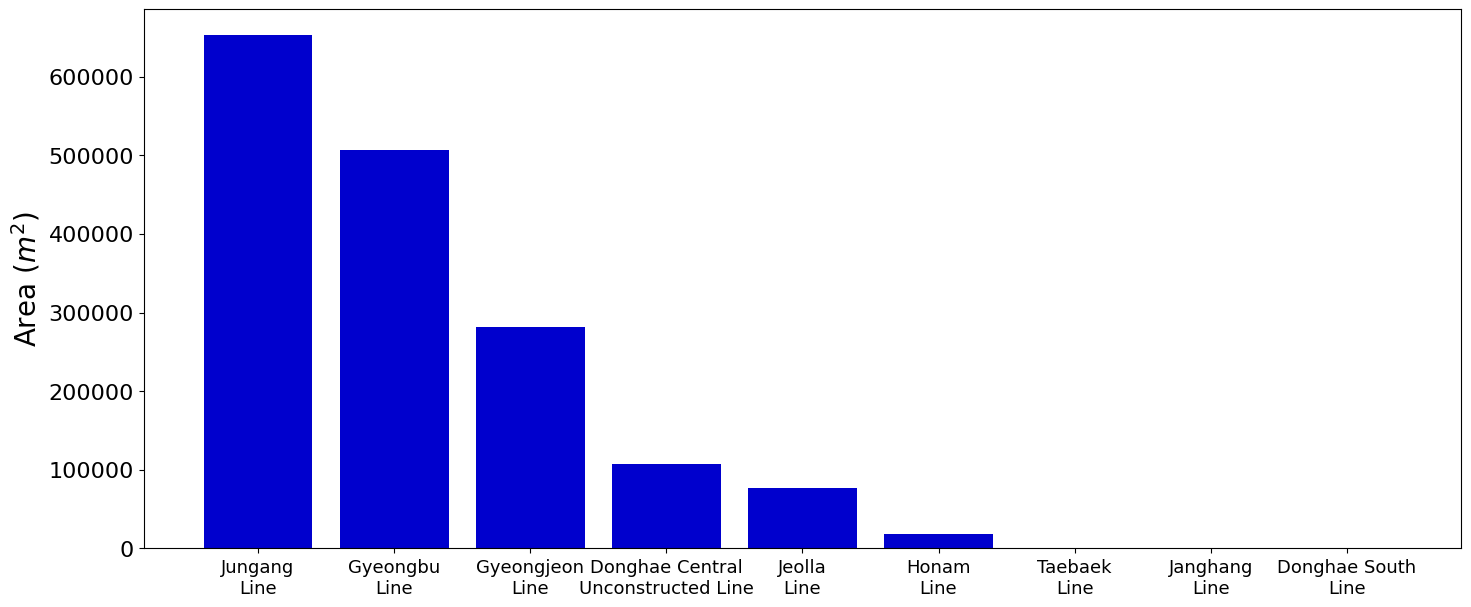

In [ ]:
# Visualization of the area of abandoned railroad tunnels

plt.figure(figsize=(17,7))
plt.rc('font', size=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=20)
plt.ylabel('Area ($m^2$)')

# Translate name of Rail Lines from Korean to English
filtered_dict_abandoned_tunnels = {k: v for k, v in RailLines_translation_dict.items() if k in Rail_lines.values}
Rail_lines_EN = Rail_lines.map(filtered_dict_abandoned_tunnels)

# plt.title('Area of abandoned railroad tunnels')
plt.bar(Rail_lines_EN,Abandoned_tunnels_Area, color='mediumblue')

plt.show()

In [ ]:
Abandoned_tunnels_Areas=pd.concat([Rail_lines, Abandoned_tunnels_Area], axis=1)
Abandoned_tunnels_Areas.rename(columns={Abandoned_tunnels_Areas.columns[1]: 'unDevelopable_Area'}, inplace=True)
Abandoned_tunnels_Areas.set_index('선 로 명', inplace=True)

# Translate name of Rail Lines from Korean to English
Abandoned_tunnels_Areas.rename(index=RailLines_translation_dict, inplace=True)
Developable_Area_EN = Developable_Area.rename(index=RailLines_translation_dict, inplace=False)
unDevelopable_Area_EN = unDevelopable_Area.rename(index=RailLines_translation_dict, inplace=False)
Final_Developable_Section = pd.concat([Actual_Developable_Section, Abandoned_tunnels_Areas], axis=1, join='outer')

# Convert NaN values to 0
Final_Developable_Section.fillna(0, inplace=True)

Final_Developable_Section['Entire_Area'] = Developable_Area_EN.loc[Actual_Developable_Section.index] + unDevelopable_Area_EN.loc[Actual_Developable_Section.index]
Final_Developable_Section['Developable_Ratio'] =  Final_Developable_Section['Developable Area'] / Final_Developable_Section['Entire_Area']
# 일단은 전체 면적 중 사용 가능 면적의 비율만큼을 폐터널에도 적용해 사용가능 면적 제외 진행
Final_Developable_Section['Final_Developable_Area'] = Final_Developable_Section['Developable Area'] - Final_Developable_Section['unDevelopable_Area'] * Final_Developable_Section['Developable_Ratio']

# Convert NaN values to 0
Final_Developable_Section.fillna(0, inplace=True)

In [ ]:
Final_Developable_Section

Developable Area  unDevelopable Area  \
Gyeongjeon\nLine                              1840496             1577321   
Donghae Central\nUnconstructed Line           1266197             1199080   
Janghang\nLine                                 933515              574142   
Jungang\nLine                                  870214             1562991   
Honam\nLine                                    417872              209757   
Jeolla\nLine                                   362858             1078118   
Gyeongbu\nLine                                 320736             1119911   
Taebaek\nLine                                  230289                   0   
Donghae South\nLine                            220839              153770   
Gyeongchun\nLine                                32012             1454825   
Samhakdo\nLine                                  11511                   0   
Gyeongbu High-Speed\nLine                        6934              165640   
Yeongdong\nLine                                  4443              612653   
Suin\nLine (Overhead)                               0               84005   
Gyeongui\nLine (Overhead)                           0               76254   
High-Speed\nLine (Overhead)                         0               21708   
Gyeonggang\nLine                                    0               12028   
Mungyeong\nLine                                     0                4109   
Additional Gyeongjeon\nLine                         0              434361   
Daejeon South\nConnection Line                      0              131855   
Imhang\nLine                                        0               71922   
Suin\nLine                                          0               38634   
Suyeon\nLine                                        0               79599   
Honam High-Speed\nLine                              0                9463   

                                     unDevelopable_Area  Entire_Area  \
Gyeongjeon\nLine                              281700.75      3417817   
Donghae Central\nUnconstructed Line           107700.00      2465277   
Janghang\nLine                                     0.00      1507657   
Jungang\nLine                                 652885.00      2433205   
Honam\nLine                                    18625.00       627629   
Jeolla\nLine                                   76930.00      1440976   
Gyeongbu\nLine                                506891.00      1440647   
Taebaek\nLine                                    840.00       230289   
Donghae South\nLine                                0.00       374609   
Gyeongchun\nLine                                   0.00      1486837   
Samhakdo\nLine                                     0.00        11511   
Gyeongbu High-Speed\nLine                          0.00       172574   
Yeongdong\nLine                                    0.00       617096   
Suin\nLine (Overhead)                              0.00        84005   
Gyeongui\nLine (Overhead)                          0.00        76254   
High-Speed\nLine (Overhead)                        0.00        21708   
Gyeonggang\nLine                                   0.00        12028   
Mungyeong\nLine                                    0.00         4109   
Additional Gyeongjeon\nLine                        0.00       434361   
Daejeon South\nConnection Line                     0.00       131855   
Imhang\nLine                                       0.00        71922   
Suin\nLine                                         0.00        38634   
Suyeon\nLine                                       0.00        79599   
Honam High-Speed\nLine                             0.00         9463   

                                     Developable_Ratio  Final_Developable_Area  
Gyeongjeon\nLine                                  0.54              1688800.02  
Donghae Central\nUnconstructed Line               0.51              1210880.94  
Janghang\nLine                                    0.62             

<ipython-input-375-f95a4b158260>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-375-f95a4b158260>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



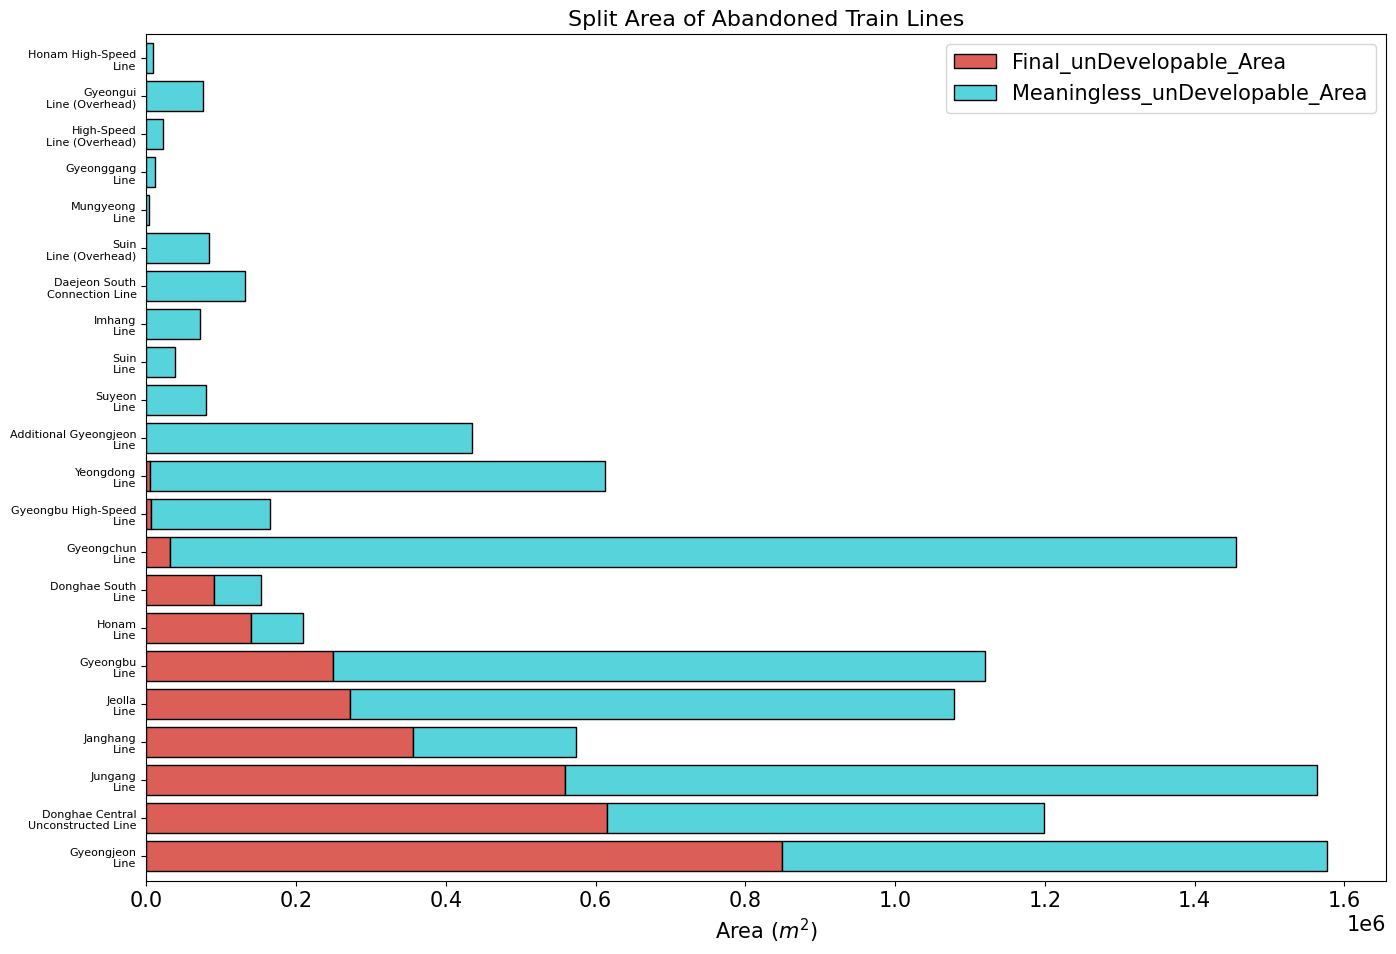

In [ ]:
# 사용 가능, 사용 불가로 범례명 변경
unDevelopable_Area_Ratio = Final_Developable_Section.loc[Final_Developable_Section['unDevelopable Area'] > 0]
unDevelopable_Area_Ratio['Final_unDevelopable_Area'] = unDevelopable_Area_Ratio['unDevelopable Area'] * unDevelopable_Area_Ratio['Developable_Ratio']
unDevelopable_Area_Ratio['Meaningless_unDevelopable_Area'] = unDevelopable_Area_Ratio['unDevelopable Area'] - unDevelopable_Area_Ratio['Final_unDevelopable_Area']
unDevelopable_Area_Ratio = unDevelopable_Area_Ratio[['Final_unDevelopable_Area', 'Meaningless_unDevelopable_Area']]

colors = sns.color_palette('hls', len(unDevelopable_Area_Ratio.columns))

unDevelopable_Area_Ratio = unDevelopable_Area_Ratio.sort_values(by='Final_unDevelopable_Area', ascending=False)

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=8)

unDevelopable_Area_Ratio.plot(kind='barh',stacked=True,figsize=(16,11),width=0.8,edgecolor='black',color=colors)

plt.title('Split Area of Abandoned Train Lines')
plt.xlabel('Area ($m^2$)')

plt.show()

## 4.3 Power production forecasting

In [ ]:
# 노선별로 묶고 각 컬럼별로 합계를 구한다.
Developable_Section_PV = Developable_Section[['solrad_annual', 'ac_annual', '노선명']]
Annual_estimated_PV_generation=Developable_Section_PV.groupby('노선명').sum().astype('float')

# Rename the column
Annual_estimated_PV_generation = Annual_estimated_PV_generation.rename(columns={'ac_annual': '연간 예측 전력발전량(kWh)'})

# Drop the column 'Sanjae Unused Land'
Annual_estimated_PV_generation.drop(index=['산재 유휴부지'], inplace=True)

# Translate name of Rail Lines from Korean to English
Annual_estimated_PV_generation.rename(index=RailLines_translation_dict, inplace=True)

# 위에서 구한 진짜 면적인 Final_Developable_Section으로 데이터 변경한다.
Developable_Section_Area_PV_generation = pd.concat([Final_Developable_Section, Annual_estimated_PV_generation], axis=1, join='outer')  # Final_Developable_Section
Developable_Section_Area_PV_generation = Developable_Section_Area_PV_generation[['Final_Developable_Area', '연간 예측 전력발전량(kWh)']]

# 1m^2당 전력생산량 값을 저장하는 칼럼 생성
Developable_Section_Area_PV_generation['전력생산량 (1㎡ 당)']=Developable_Section_Area_PV_generation['연간 예측 전력발전량(kWh)']/Developable_Section_Area_PV_generation['Final_Developable_Area']

# Convert NaN and inf value to 0
Developable_Section_Area_PV_generation.replace([np.nan, np.inf], 0, inplace=True)

## 4.4 Evaluation of Economic Feasibility (Cost-effectiveness analysis)

### a. Regional power demand-supply

In [ ]:
Developable_Section_Area_PV_generation

Final_Developable_Area  연간 예측 전력발전량(kWh)  \
Gyeongjeon\nLine                                 1688800.02      415317346.16   
Donghae Central\nUnconstructed Line              1210880.94      278572617.79   
Janghang\nLine                                    933515.00      208274100.30   
Jungang\nLine                                     636715.52      198292976.07   
Honam\nLine                                       405471.58       92221660.22   
Jeolla\nLine                                      343485.95       82700823.94   
Gyeongbu\nLine                                    207885.18       72955158.54   
Taebaek\nLine                                     229449.00       52633559.69   
Donghae South\nLine                               220839.00       49397140.86   
Gyeongchun\nLine                                   32012.00        7233790.32   
Samhakdo\nLine                                     11511.00        2406762.98   
Gyeongbu High-Speed\nLine                           6934.00        1583644.12   
Yeongdong\nLine                                     4443.00        1020939.81   
Suin\nLine (Overhead)                                  0.00              0.00   
Gyeongui\nLine (Overhead)                              0.00              0.00   
High-Speed\nLine (Overhead)                            0.00              0.00   
Gyeonggang\nLine                                       0.00              0.00   
Mungyeong\nLine                                        0.00              0.00   
Additional Gyeongjeon\nLine                            0.00              0.00   
Daejeon South\nConnection Line                         0.00              0.00   
Imhang\nLine                                           0.00              0.00   
Suin\nLine                                             0.00              0.00   
Suyeon\nLine                                           0.00              0.00   
Honam High-Speed\nLine                                 0.00              0.00   

                                     전력생산량 (1㎡ 당)  
Gyeongjeon\nLine                           245.92  
Donghae Central\nUnconstructed Line        230.06  
Janghang\nLine                             223.11  
Jungang\nLine                              311.43  
Honam\nLine                                227.44  
Jeolla\nLine                               240.77  
Gyeongbu\nLine                             350.94  
Taebaek\nLine                              229.39  
Donghae South\nLine                        223.68  
Gyeongchun\nLine                           225.97  
Samhakdo\nLine                             209.08  
Gyeongbu High-Speed\nLine                  228.39  
Yeongdong\nLine                            229.79  
Suin\nLine (Overhead)                        0.00  
Gyeongui\nLine (Overhead)                    0.00  
High-Speed\nLine (Overhead)                  0.00  
Gyeonggang\nLine                             0.00  
Mungyeong\nLine                              0.00  
Additional Gyeongjeon\nLine                  0.00  
Daejeon South\nConnection Line               0.00  
Imhang\nLine                                 0.00  
Suin\nLine                                   0.00  
Suyeon\nLine                                 0.00  
Honam High-Speed\nLine                       0.00

### b. Power production efficiency per track gauge

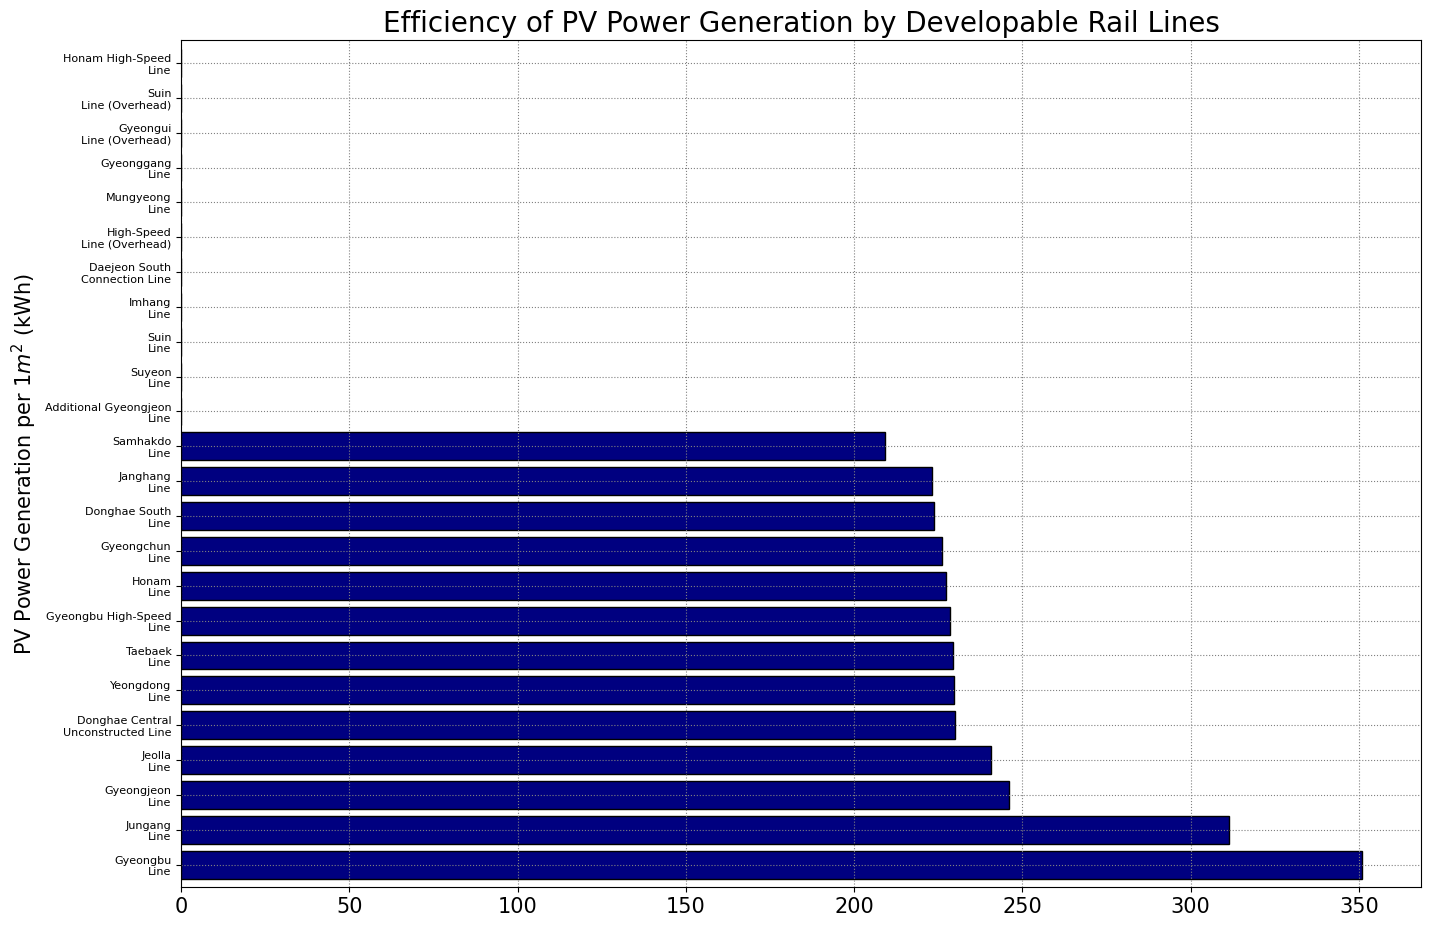

In [ ]:
# 폐철도의 전력 생산량 시각화를 통한 철도별 효율 비교
Developable_Section_Area_PV_generation = Developable_Section_Area_PV_generation.sort_values(by='전력생산량 (1㎡ 당)', ascending=False)

# Translate name of Rail Lines from Korean to English
Developable_Section_Area_PV_generation.rename(index=RailLines_translation_dict, inplace=True)

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=8)

# plt.figure(figsize=(27,8))
Developable_Section_Area_PV_generation['전력생산량 (1㎡ 당)'].plot(kind='barh', stacked=True, figsize=(16, 11), width=0.8, edgecolor='black', color=dark_blue_color)
# plt.rc('font', size=15)

plt.grid(linestyle=':',color='0.5')
plt.title('Efficiency of PV Power Generation by Developable Rail Lines', fontsize=20)
plt.ylabel('PV Power Generation per 1$m^2$ (kWh)')
# line=plt.bar(Developable_Section_Area_PV_generation.index,Developable_Section_Area_PV_generation['전력생산량 (1㎡ 당)'],color='blue')

plt.show()

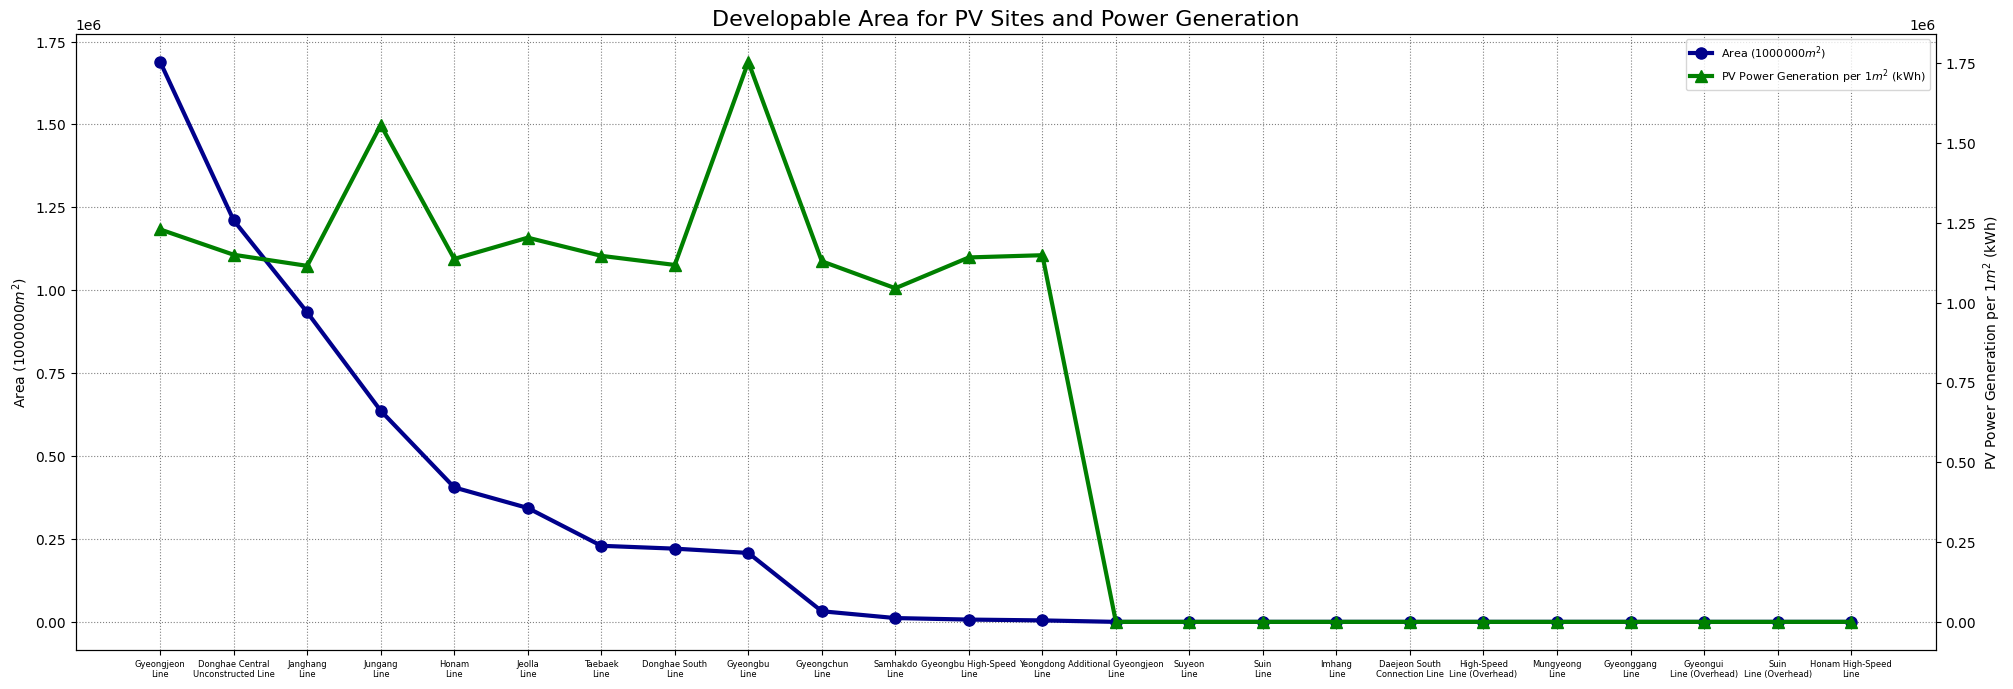

In [ ]:
Developable_Section_Area_PV_generation = Developable_Section_Area_PV_generation.sort_values(by='Final_Developable_Area', ascending=False)

plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=10)

fig, ax1 = plt.subplots(figsize=(24,8))
plt.grid(True,linestyle=':',color='0.5')
line1=ax1.plot(Developable_Section_Area_PV_generation.index,Developable_Section_Area_PV_generation['Final_Developable_Area'],color='darkblue',linewidth=3.0,label='태양광 부지로 사용 가능한 면적(미사용중인 철도의 면적)',marker='o',markersize=8)
ax1.set_ylabel('Area (1000000$m^2$)')

ax2=ax1.twinx()
line2=ax2.plot(Developable_Section_Area_PV_generation.index,Developable_Section_Area_PV_generation['전력생산량 (1㎡ 당)']*5000,color='green',linewidth=3.0,label='전력 생산 효율',marker='^',markersize=8)
ax2.set_ylabel('PV Power Generation per 1$m^2$ (kWh)')

# 그래프 설정
plt.title('Developable Area for PV Sites and Power Generation')
ax1.legend(line1+line2,['Area (1000000$m^2$)','PV Power Generation per 1$m^2$ (kWh)'],fontsize=8, loc='upper right')
plt.show()

### c. ROI for PVs along a route

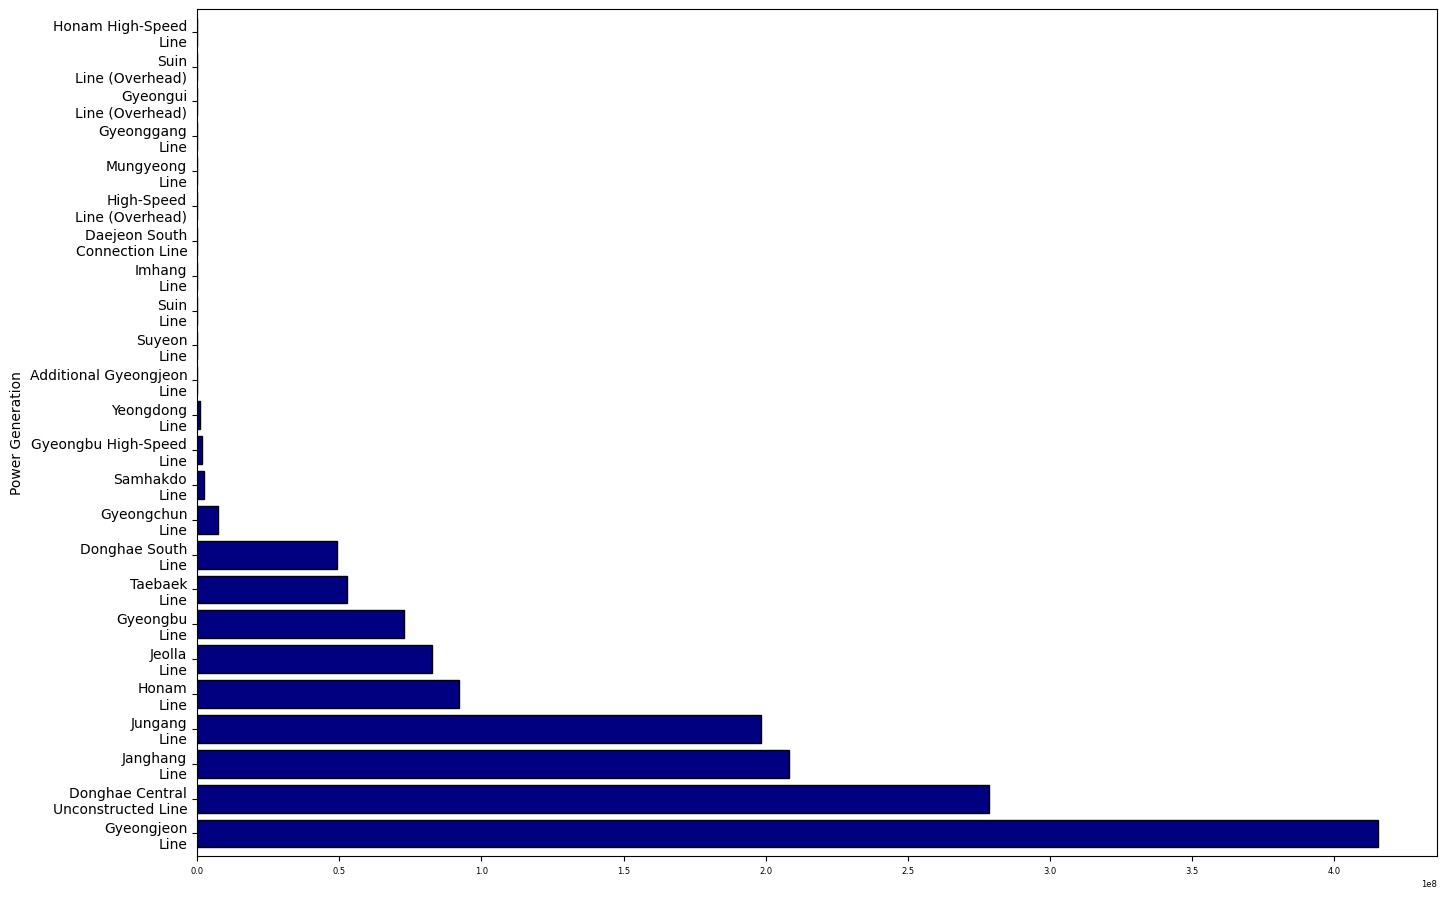

In [ ]:
# 전력 발전량 예측
Developable_Section_Area_PV_generation = Developable_Section_Area_PV_generation.sort_values(by='연간 예측 전력발전량(kWh)', ascending=False)

Developable_Section_Area_PV_generation['연간 예측 전력발전량(kWh)'].plot(kind='barh', stacked=True, figsize=(16, 11), width=0.8, edgecolor='black', color=dark_blue_color)
# plt.figure(figsize=(22,8))
plt.rc('font', size=15)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=15)
plt.ylabel('Power Generation')
# plt.xticks(rotation=50)
# plt.title('Annual Predicted Power Generation by Abandoned Railroad Sections')
# plt.bar(Developable_Section_Area_PV_generation.index,Developable_Section_Area_PV_generation['연간 예측 전력발전량(kWh)'], color='royalblue')
# plt.tight_layout()
plt.show()

In [ ]:
# # Top 5 Rail Lines
# Top5_RailLines=['Gyeongjeon\nLine','Janghang\nLine','Donghae Central\nUnconstructed Line','Jungang\nLine','Gyeongbu\nLine']
# Developable_Section_Area_PV_generation_Top5=Developable_Section_Area_PV_generation.loc[Top5_RailLines]

# 이거 면적합이 아니라 발전량 합 맞는지?
# Top 5 폐철도의 남은 폐철도 유휴부지 면적의 합
Developable_Section_Area_PV_generation_annually=Developable_Section_Area_PV_generation['연간 예측 전력발전량(kWh)'].sum()

# 남은 유휴부지의 kw시 계산==남은 유휴부지 전체에 태양광을 설치했을 떄 시간당 발전
Developable_Section_Area_PV_generation_hourly=(Developable_Section_Area_PV_generation_annually)/(365*24)

# 전력 판매 비용=설비용량(1시간당 생산 전력)*일평균 발전시간(3.6)*365(일)*SMP(계통한계가격)
power_SellPrice=Developable_Section_Area_PV_generation_hourly*(3.6)*(365)*(151)

# 공급인증서 판매=설비용량*일평균 발전시간(3.6)*연일수(365)*지목별 가중치(0.8)*REC(60426)/1000
author_KeyPrice=(Developable_Section_Area_PV_generation_hourly*3.6*365*0.8*60426)/1000

all_price=power_SellPrice+author_KeyPrice

# 총 비용
install_Sum=(Developable_Section_Area_PV_generation_hourly/100)*150000000

install_Sum/all_price

5.726637554457116

In [ ]:
def calc_annual_revenue(RailLine):

  Developable_Section_Area_PV_generation_loc=Developable_Section_Area_PV_generation.loc[RailLine]

  # Top 5 폐철도의 남은 폐철도 유휴부지 면적의 합
  # 이거도 발전량 합?
  Total_Developable_Section_PV_generation_annually=Developable_Section_Area_PV_generation_loc['연간 예측 전력발전량(kWh)']

  # 남은 유휴부지의 kw시 계산==남은 유휴부지 전체에 태양광을 설치했을 떄 시간당 발전
  Total_Developable_Section_PV_generation_hourly=(Total_Developable_Section_PV_generation_annually)/(365*24)

  # 전력 판매 비용=설비용량(1시간당 생산 전력)*일평균 발전시간(3.6)*365(일)*SMP(계통한계가격)
  power_SellPrice=Total_Developable_Section_PV_generation_hourly*(3.6)*(365)*(151)

  # 공급인증서 판매=설비용량*일평균 발전시간(3.6)*연일수(365)*지목별 가중치(0.8)*REC(60426)/1000
  author_KeyPrice=(Total_Developable_Section_PV_generation_hourly*3.6*365*0.8*60426)/1000

  all_price=power_SellPrice+author_KeyPrice
  Revenue_list.append(all_price)

In [ ]:
Revenue_list=[]
for RailLine in Developable_Section_Area_PV_generation.index:
  calc_annual_revenue(RailLine)

In [ ]:
Revenue = pd.Series(Revenue_list)
Revenue.index = Developable_Section_Area_PV_generation.index
Revenue = Revenue.sort_values(ascending=False)

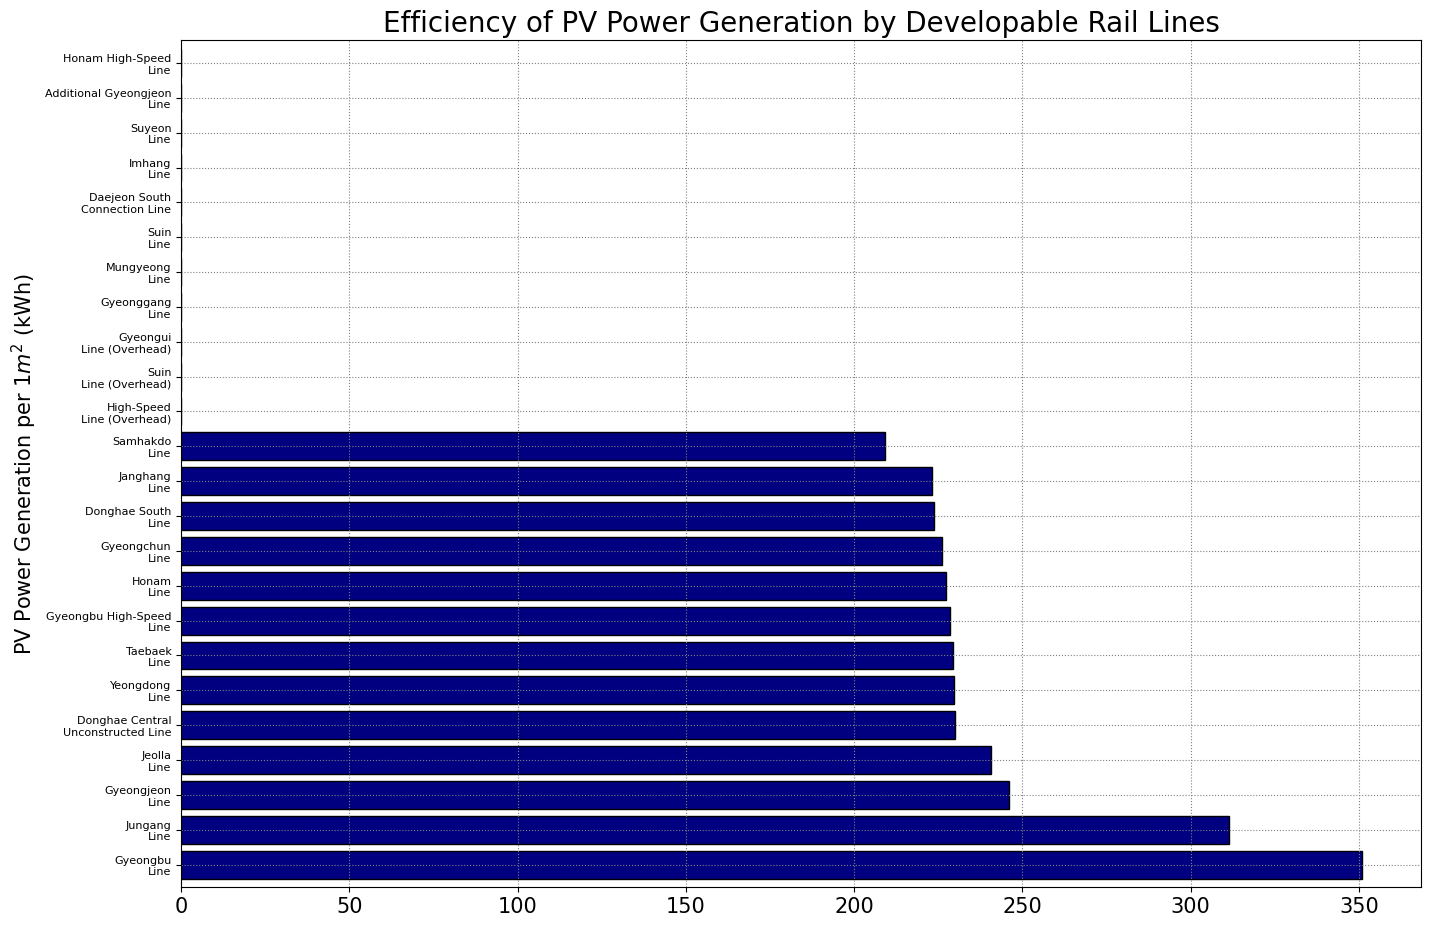

In [ ]:
# plt.figure(figsize=(27,8))
Developable_Section_Area_PV_generation = Developable_Section_Area_PV_generation.sort_values(by='전력생산량 (1㎡ 당)', ascending=False)

Developable_Section_Area_PV_generation['전력생산량 (1㎡ 당)'].plot(kind='barh', stacked=True, figsize=(16, 11), width=0.8, edgecolor='black', color=dark_blue_color)
# plt.rc('font', size=15)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=8)
plt.grid(linestyle=':',color='0.5')
plt.title('Efficiency of PV Power Generation by Developable Rail Lines', fontsize=20)
plt.ylabel('PV Power Generation per 1$m^2$ (kWh)')
# line=plt.bar(Developable_Section_Area_PV_generation.index,Developable_Section_Area_PV_generation['전력생산량 (1㎡ 당)'],color='blue')

plt.show()

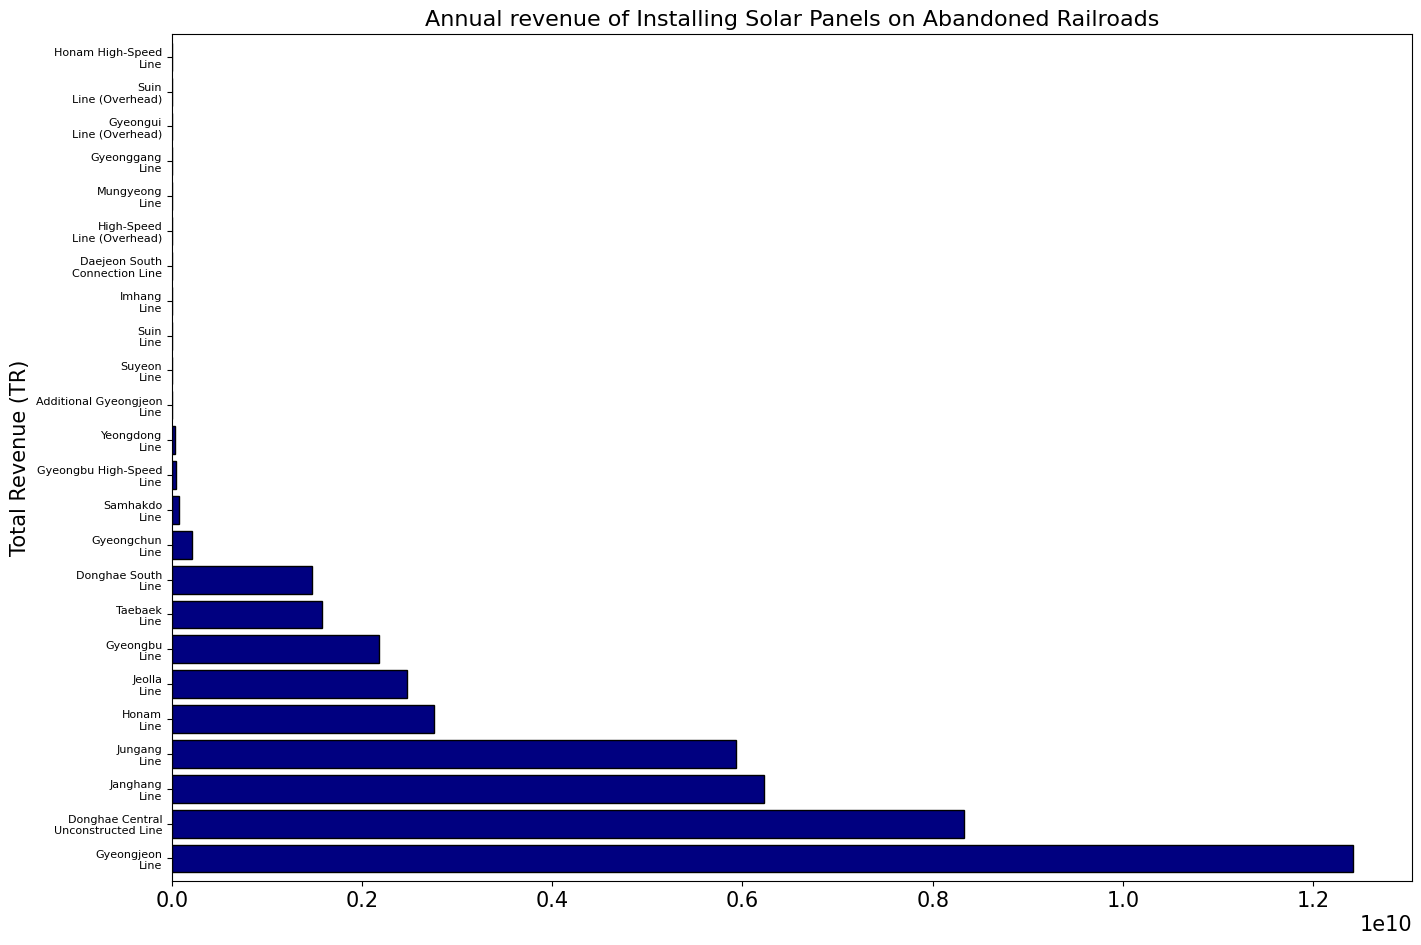

In [ ]:
# 수익 그래프 시각화
Revenue.plot(kind='barh', stacked=True, figsize=(16, 11), width=0.8, edgecolor='black', color=dark_blue_color)

# plt.figure(figsize=(20,8))
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=8)
# plt.grid(linestyle=':',color='0.3')

plt.title('Annual revenue of Installing Solar Panels on Abandoned Railroads')
plt.ylabel('Total Revenue (TR)', fontsize=15)

# plt.bar(Revenue.index,Revenue.values,color='darkblue',linewidth=4.0)

plt.show()

## 4.5 Carbon footprint measurement

In [ ]:
# Top5_High_Economic_Feasibility_RailLines_EN = ['Gyeongjeon\nLine', 'Donghae Central\nUnconstructed Line', 'Janghang\nLine', 'Jungang\nLine', 'Gyeongbu\nLine']

Developable_Section_Area_PV_generation['Carbon_Emissions (MWh)'] = Developable_Section_Area_PV_generation['연간 예측 전력발전량(kWh)'] * 0.000366 / 1000
Developable_Section_Area_PV_generation = Developable_Section_Area_PV_generation.sort_values(by='Carbon_Emissions (MWh)', ascending=False)

# Developable_Section_Area_PV_generation = Developable_Section_Area_PV_generation.loc[Top5_High_Economic_Feasibility_RailLines_EN]
Developable_Section_Area_PV_generation['Carbon_Emissions (MWh)']

Gyeongjeon\nLine                      152.01
Donghae Central\nUnconstructed Line   101.96
Janghang\nLine                         76.23
Jungang\nLine                          72.58
Honam\nLine                            33.75
Jeolla\nLine                           30.27
Gyeongbu\nLine                         26.70
Taebaek\nLine                          19.26
Donghae South\nLine                    18.08
Gyeongchun\nLine                        2.65
Samhakdo\nLine                          0.88
Gyeongbu High-Speed\nLine               0.58
Yeongdong\nLine                         0.37
High-Speed\nLine (Overhead)             0.00
Suin\nLine (Overhead)                   0.00
Gyeongui\nLine (Overhead)               0.00
Gyeonggang\nLine                        0.00
Mungyeong\nLine                         0.00
Suin\nLine                              0.00
Daejeon South\nConnection Line          0.00
Imhang\nLine                            0.00
Suyeon\nLine                            0.00
Additional

In [ ]:
# # 연간 전력 발전량에 대응해서 탄소 배출량 계산(0.000366) -> 그래프 시각
# Top5_High_Economic_Feasibility_RailLines_EN = ['Gyeongjeon\nLine', 'Donghae Central\nUnconstructed Line', 'Janghang\nLine', 'Jungang\nLine', 'Gyeongbu\nLine']

# Developable_Section_Area_PV_generation['Carbon_Emissions (MWh)'] = Developable_Section_Area_PV_generation['연간 예측 전력발전량(kWh)'] * 0.000366 / 1000
# Developable_Section_Area_PV_generation = Developable_Section_Area_PV_generation.sort_values(by='Carbon_Emissions (MWh)', ascending=False)

# Developable_Section_Area_PV_generation = Developable_Section_Area_PV_generation.loc[Top5_High_Economic_Feasibility_RailLines_EN]

# plt.figure(figsize=(8,6))
# plt.rc('axes', labelsize=10)
# plt.rc('xtick', labelsize=10)
# plt.rc('ytick', labelsize=10)
# plt.title('Carbon Footprint Analysis')
# plt.ylabel('Carbon Emission (t$CO_2$eq)', fontsize=15)

# plt.bar(Developable_Section_Area_PV_generation.index,Developable_Section_Area_PV_generation['Carbon_Emissions (MWh)'],color='dodgerblue',linewidth=2.0)

# plt.show()

## 4.6 Assessing and ranking candidates

In [ ]:
Estimated_PV_generation['solrad_annual'] = Estimated_PV_generation['solrad_annual'].astype(int)
px.set_mapbox_access_token(open("./mapbox_token.py").read())

Top5_High_Economic_Feasibility_RailLines = ['경전선', '동해중부 미건설선', '장항선', '중앙선', '경부선']

for High_Economic_Feasibility_RailLine in Top5_High_Economic_Feasibility_RailLines:
  Top5_High_Economic_Feasibility_RailLines_Distribution=Developable_Section[Developable_Section['노선명'] == High_Economic_Feasibility_RailLine]

  fig = px.scatter_mapbox(Top5_High_Economic_Feasibility_RailLines_Distribution, lat="lat", lon="lng", color='solrad_annual',hover_name="주소",hover_data=["solrad_annual","노선명","면적"],
                          color_continuous_scale=px.colors.cyclical.IceFire,zoom=7
                        )

  fig.update_layout(mapbox={'style':'dark','zoom':7},showlegend=False)
  fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
  fig.show()

In [ ]:
# 위의 Top5 합친 그래프
Top5_Developable_Section = Developable_Section[Developable_Section['노선명'].isin(Top5_High_Economic_Feasibility_RailLines)]

fig = px.scatter_mapbox(Top5_Developable_Section, lat="lat", lon="lng", color='solrad_annual',hover_name="주소",hover_data=["solrad_annual","노선명",'면적'],
                        color_continuous_scale=px.colors.cyclical.IceFire,zoom=7
                       )

fig.update_layout(mapbox={'style':'dark','zoom':7},showlegend=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()